In [218]:
## first line of code is to clear R's memory
rm(list=ls())

In [219]:
#libraries
if (!requireNamespace("EnsDb.Hsapiens.v75", quietly = TRUE))
  BiocManager::install("EnsDb.Hsapiens.v75")
library(Signac)
library(Seurat)
library(rtracklayer)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(readr)
library(qs)
library(dplyr)
library(stringr)
library(harmony)
library(Azimuth)
library(EnsDb.Hsapiens.v86)

In [220]:
#####################
#Annotation
###################
adipose_tissue <- readRDS("complete/GSE184462_merged_1_3_newpeaks.rds")

# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)

# change to UCSC style since the data was mapped to hg38
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "hg38"

# add the gene information to the object
Annotation(adipose_tissue) <- annotations
    

In [ ]:
#####################
#QC Metrics
###################
# compute nucleosome signal score per cell
adipose_tissue <- NucleosomeSignal(object = adipose_tissue)

# compute TSS enrichment score per cell
adipose_tissue <- TSSEnrichment(object = adipose_tissue, fast = FALSE)

In [178]:
##########################
#Normalization and linear dimensional reduction
#########################
adipose_tissue <- RunTFIDF(adipose_tissue)
adipose_tissue <- FindTopFeatures(adipose_tissue, min.cutoff = 'q0')
adipose_tissue <- RunSVD(adipose_tissue)


Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations

06:07:48 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

06:07:48 Read 12302 rows and found 29 numeric columns

06:07:48 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

06:07:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

06:07:49 Writing NN index file to temp file /tmp/RtmpxfMO5U/file106886acbcfb

06:07:49 Searching Annoy index using 1 thread, search_k = 3000

06:07:53 Annoy recall = 100%

06:07:59 Commencing smooth kNN distance calibration using 1 thread
 with target n_

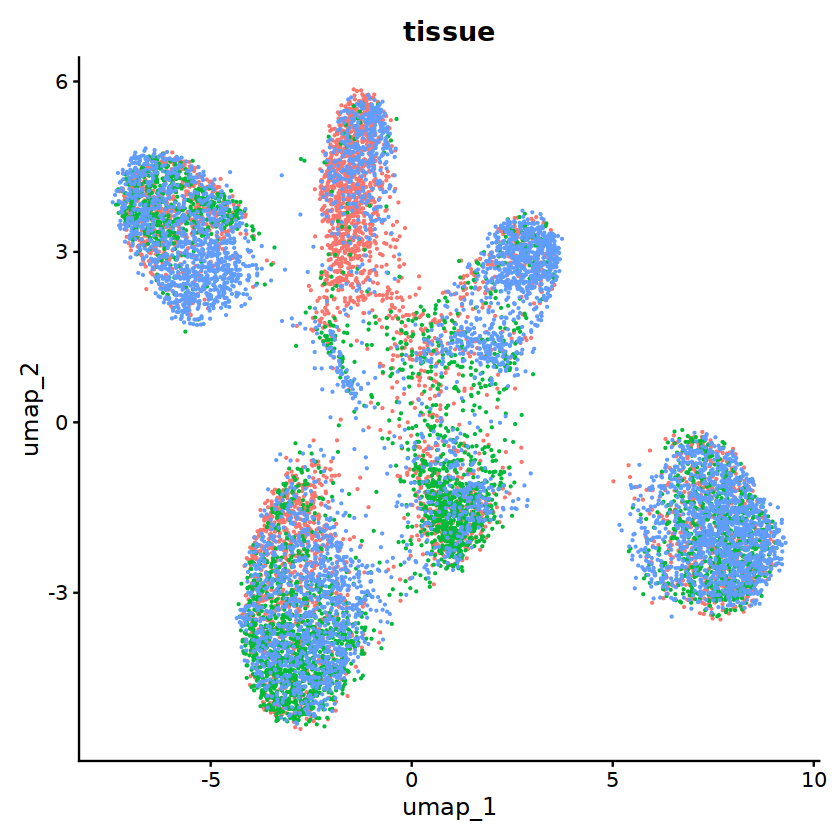

In [179]:
##########################
#Non-linear dimension reduction and clustering
##########################
adipose_tissue <- RunHarmony(adipose_tissue, group.by.vars = "tissue", reduction = 'lsi', assay.use = 'peaks', project.dim = FALSE)
adipose_tissue <- RunUMAP(adipose_tissue, reduction = "harmony", dims = 2:30)
adipose_tissue <- FindNeighbors(object = adipose_tissue, reduction = 'harmony', dims = 2:30)
adipose_tissue <- FindClusters(object = adipose_tissue, verbose = FALSE, algorithm = 3)
DimPlot(object = adipose_tissue, group.by = 'tissue') + NoLegend()

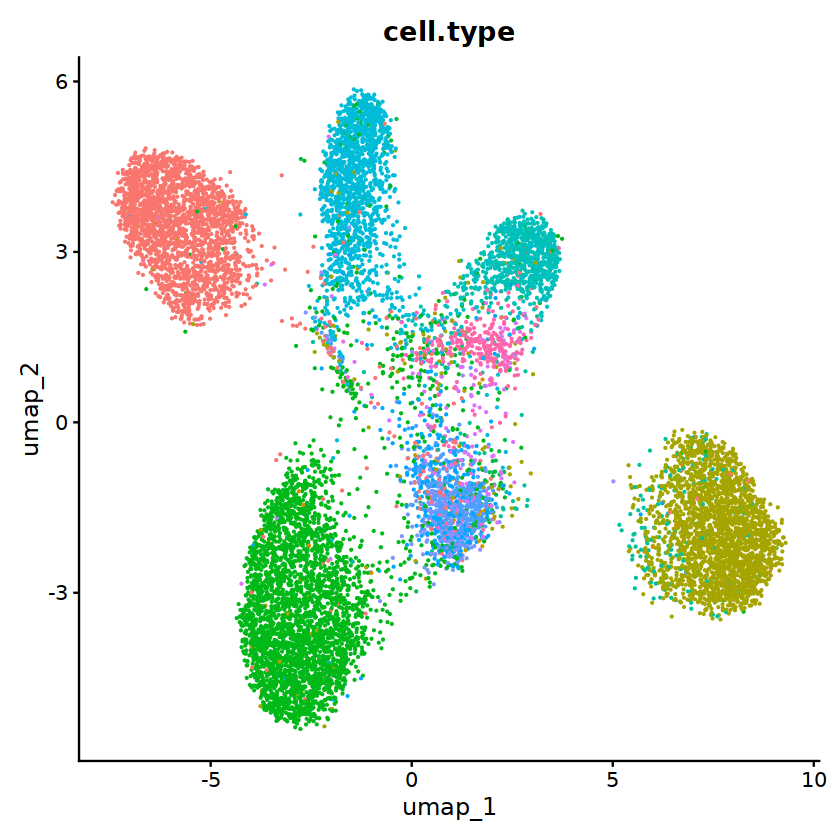

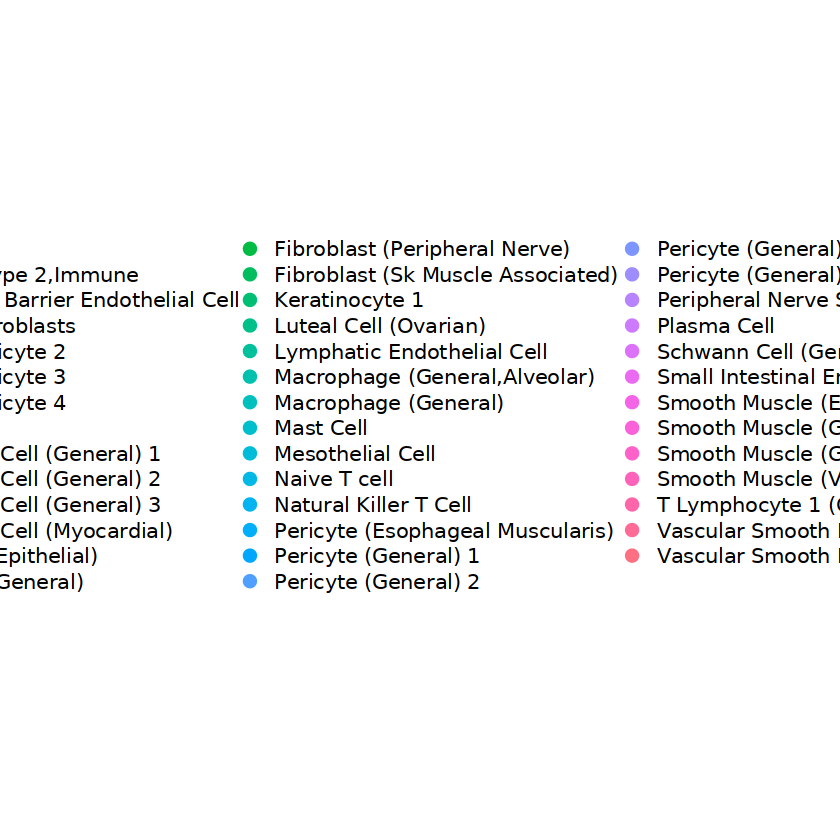

In [180]:
DimPlot(object = adipose_tissue, group.by = 'cell.type') + NoLegend()
DimPlot(object = adipose_tissue, group.by = 'cell.type')

In [181]:
##########################
#Create a gene activity matrix
#########################
gene.activities <- GeneActivity(adipose_tissue)
# add the gene activity matrix to the Seurat object as a new assay and normalize it
adipose_tissue[['RNA']] <- CreateAssayObject(counts = gene.activities)

#adipose_tissue <- NormalizeData(
#  object = adipose_tissue,
#  assay = 'RNA',
#  normalization.method = 'LogNormalize',
#  scale.factor = median(adipose_tissue$nCount_RNA)
#)

Extracting gene coordinates

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



Warning message:
"Overwriting miscellanous data for model"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
detected inputs from HUMAN with id type Gene.name

reference rownames detected HUMAN with id type Gene.name

Normalizing query using reference SCT model

Warning message:
"702 features of the features specified were not present in both the reference query assays. 
Continuing with remaining 2298 features."
Projecting cell embeddings

Finding query neighbors

Finding neighborhoods

Finding anchors

	Found 2067 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key

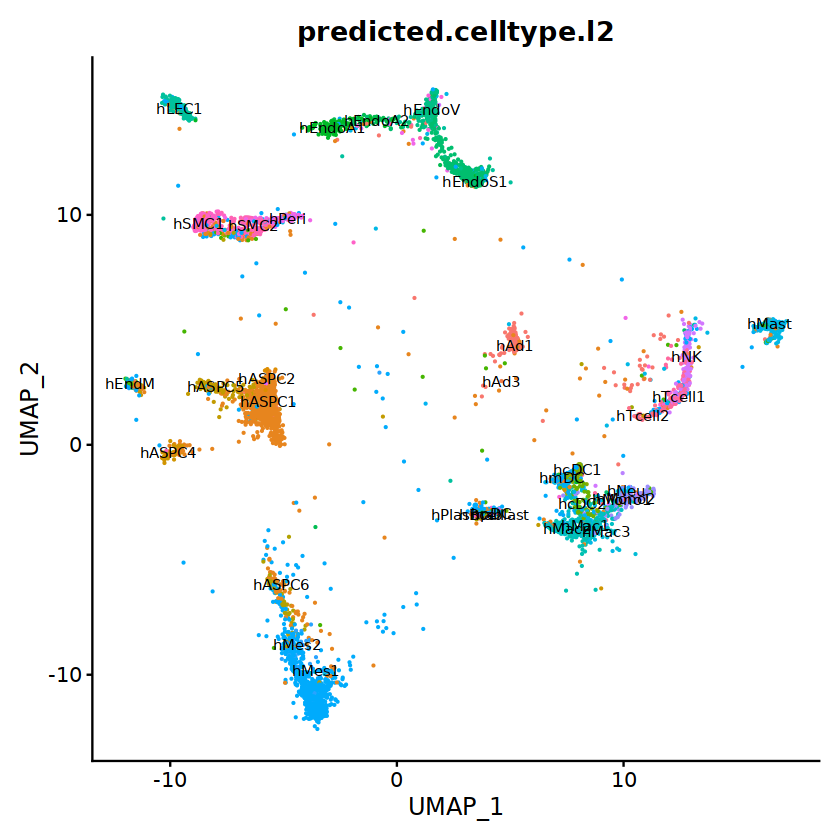

In [182]:
DefaultAssay(adipose_tissue) <- "RNA"

az <- RunAzimuth(adipose_tissue, reference = "adiposeref", assay = "RNA")
DimPlot(az, group.by = "predicted.celltype.l2", label = TRUE, label.size = 3) + NoLegend()

In [183]:
az[[]][c(9,20,22)]


,cell.type,predicted.celltype.l1,predicted.celltype.l2
,<chr>,<chr>,<chr>
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGAAGTGTCGTGGA,Mesothelial Cell,Mesothelial,hMes1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGACATGGCAAGCC,Fibroblast (General),ASPC,hASPC1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGAGCATACTCAGC,Fibroblast (General),Smooth Muscle,hSMC1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGAGGGATCCATTA,Fibroblast (General),ASPC,hASPC1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGATGACCACCAAT,Fibroblast (General),ASPC,hMast
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGATTACTCGTGGG,Pericyte (General) 3,ASPC,hASPC1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCACGCAAGGGAA,Fibroblast (General),ASPC,hASPC1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCAGTGATTCTGT,Mesothelial Cell,ASPC,hASPC1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCGAACGATACAG,Pericyte (General) 1,ASPC,hMes1


In [ ]:
#Azimuth with different reference
az <- RunAzimuth(adipose_tissue, reference = "pbmcref", assay = "RNA")
DimPlot(az, group.by = "predicted.celltype.l2", label = TRUE, label.size = 3) + NoLegend()
az[[]][c(9,18,20)]

In [185]:
az$correctcall <- FALSE
#Mesothel
az$correctcall[az$cell.type=="Mesothelial Cell" & az$predicted.celltype.l1=="Mesothelial"] <- TRUE
#Adipocytes
az$correctcall[az$cell.type=="Adipocyte" & az$predicted.celltype.l1 %in% c("Adipocyte", "ASPC")] <- TRUE
#Endothel
az$correctcall[az$cell.type=="Endothelial Cell (General) 1" & az$predicted.celltype.l1=="Endothelial"] <- TRUE
az$correctcall[az$cell.type=="Endothelial Cell (General) 2" & az$predicted.celltype.l1=="Endothelial"] <- TRUE
az$correctcall[az$cell.type=="Endothelial Cell (General) 3" & az$predicted.celltype.l1=="Endothelial"] <- TRUE
az$correctcall[az$cell.type=="Endothelial Cell (Myocardial)" & az$predicted.celltype.l1=="Endothelial"] <- TRUE
az$correctcall[az$cell.type=="Alveolar Capillary Endothelial Cell" & az$predicted.celltype.l1=="Endothelial"] <- TRUE
az$correctcall[az$cell.type=="Lymphatic Endothelial Cell" & az$predicted.celltype.l1=="Lymphatic Endothelial"] <- TRUE
#Macrophages
az$correctcall[az$cell.type=="Macrophage (General)" & az$predicted.celltype.l1=="Macrophage"] <- TRUE
az$correctcall[az$cell.type=="Macrophage (General,Alveolar)" & az$predicted.celltype.l1=="Macrophage"] <- TRUE
#Pericytes
az$correctcall[az$cell.type=="Pericyte (General) 1" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Pericyte (General) 2" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Pericyte (General) 3" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Pericyte (General) 4" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Cardiac Pericyte 2" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Cardiac Pericyte 3" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Cardiac Pericyte 4" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Pericyte (Esophageal Muscularis)" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
#Smooth Muscle
az$correctcall[az$cell.type=="Smooth Muscle (General)" & az$predicted.celltype.l1=="Smooth Muscle"] <- TRUE
az$correctcall[az$cell.type=="Vascular Smooth Muscle 1" & az$predicted.celltype.l1=="Smooth Muscle"] <- TRUE
az$correctcall[az$cell.type=="Vascular Smooth Muscle 2" & az$predicted.celltype.l1=="Smooth Muscle"] <- TRUE
az$correctcall[az$cell.type=="Smooth Muscle (GE Junction)" & az$predicted.celltype.l1=="Smooth Muscle"] <- TRUE
#Immune cells
az$correctcall[az$cell.type=="Naive T cell" & az$predicted.celltype.l1=="T"] <- TRUE
az$correctcall[az$cell.type=="Natural Killer T Cell" & az$predicted.celltype.l1 %in% c("T", "NK")] <- TRUE
az$correctcall[az$cell.type=="Mast Cell" & az$predicted.celltype.l1=="Mast"] <- TRUE



In [186]:
az_types <- c("Mesothelial Cell", "Adipocyte", "Endothelial Cell (General) 1", "Endothelial Cell (General) 2",
             "Endothelial Cell (General) 3", "Endothelial Cell (Myocardial)","Lymphatic Endothelial Cell", 
              "Pericyte (General) 1", "Pericyte (General) 2", "Pericyte (General) 3", "Pericyte (General) 4", 
              "Cardiac Pericyte 2", "Cardiac Pericyte 3", "Cardiac Pericyte 4", "Pericyte (Esophageal Muscularis)", 
              "Smooth Muscle (General)", "Vascular Smooth Muscle 1", "Vascular Smooth Muscle 2",
              "Naive T cell", "Natural Killer T Cell", "Mast Cell")
az_sub <- subset(az, cell.type %in% az_types)

In [188]:
az_quality <- data.frame(row.names = az_types)


In [189]:
for (i in seq(1,length(az_types))){
    temp <- subset(az_sub, cell.type == az_types[i])
    total <- length(temp$cell.type)
    correct <-  sum(temp$correctcall, na.rm = TRUE)
    az_quality[i,1] <- total
    az_quality[i,2] <- correct
    
}

In [190]:
colnames(az_quality) <- c("total", "correct")
az_quality <- mutate(az_quality, false = total - correct)
az_quality <- mutate(az_quality, perc.correct = correct/total)
az_quality <- mutate(az_quality, perc.false = false/total)
az_quality$id <- rownames(az_quality)


In [191]:
az_quality$id <- c("Mesothelial Cell", "Adipocyte", "Endothelial Cell", "Endothelial Cell",
             "Endothelial Cell", "Endothelial Cell","Lymphatic Endothelial Cell", 
              "Pericyte", "Pericyte", "Pericyte", "Pericyte", 
              "Pericyte", "Pericyte", "Pericyte", "Pericyte", 
              "Smooth Muscle", "Smooth Muscle", "Smooth Muscle",
              "Naive T cell", "Natural Killer T Cell", "Mast Cell")



In [192]:
az_quality

,total,correct,false,perc.correct,perc.false,id
,<int>,<int>,<int>,<dbl>,<dbl>,<chr>
Mesothelial Cell,1557,1121,436,0.719974310,0.2800257,Mesothelial Cell
Adipocyte,2195,764,1431,0.348063781,0.6519362,Adipocyte
Endothelial Cell (General) 1,2348,1935,413,0.824105622,0.1758944,Endothelial Cell
Endothelial Cell (General) 2,160,138,22,0.862500000,0.1375000,Endothelial Cell
Endothelial Cell (General) 3,6,6,0,1.000000000,0.0000000,Endothelial Cell
Endothelial Cell (Myocardial),12,10,2,0.833333333,0.1666667,Endothelial Cell
Lymphatic Endothelial Cell,186,137,49,0.736559140,0.2634409,Lymphatic Endothelial Cell
Pericyte (General) 1,354,60,294,0.169491525,0.8305085,Pericyte
Pericyte (General) 2,281,1,280,0.003558719,0.9964413,Pericyte


In [193]:
df <- az_quality
df$id <- NULL

#Combine enodthelial cells
df[3,]<-df[3,]+df[4,]+df[5,]+df[6,]
df <-df[c(-4,-5,-6),]

#combine pericytes
df[5,]<-df[5,]+df[6,]+df[7,]+df[8,]+df[9,]+df[10,]+df[11,]+df[12,]
df <-df[c(-6,-7,-8,-9,-10,-11,-12),]
df[6,]<-df[6,]+df[7,]+df[8,]
df <-df[c(-7,-8),]

df$id <- c("Mesothelial Cell", "Adipocyte", "Endothelial Cell","Lymphatic Endothelial Cell", 
              "Pericyte","Smooth Muscle", "Naive T cell", "Natural Killer T Cell", "Mast Cell")


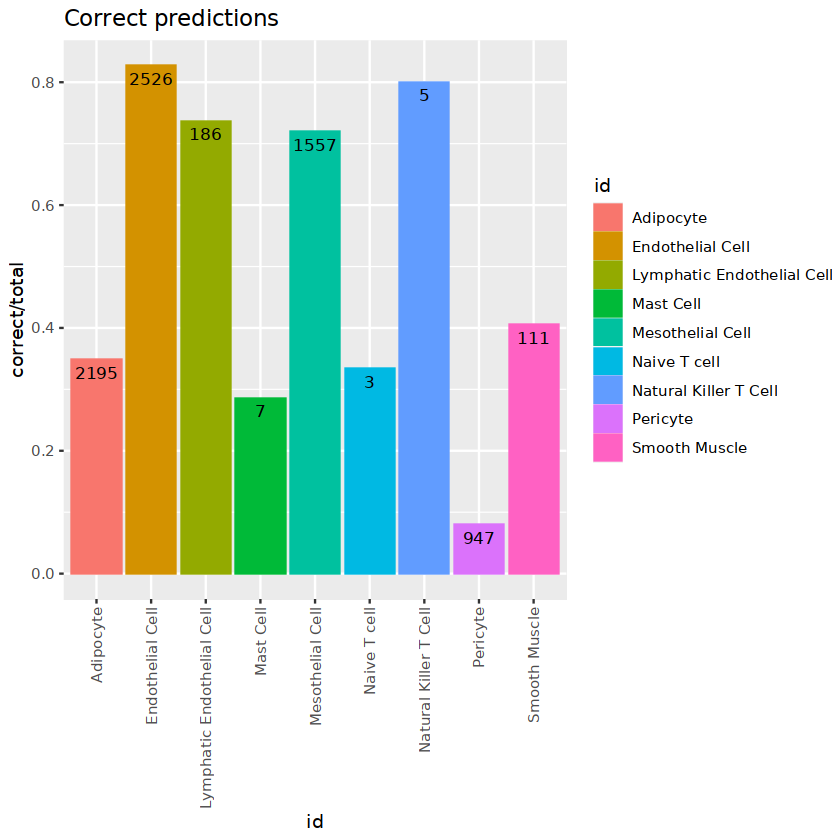

In [195]:
ggplot(df, aes(x= id, y = correct/total, color = id, fill = id))+
geom_bar(stat="identity")+
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
ggtitle("Correct predictions")+
geom_text(aes(label=total), vjust=1.6, color="black",
            position = position_dodge(0.9), size=3.5)